# Clustering Crypto

In [64]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Fetching Cryptocurrency Data

In [65]:
# Use the following endpoint to fetch json data
import json
from urllib.request import Request, urlopen

url = "https://min-api.cryptocompare.com/data/all/coinlist"
j_request = Request(url)
j_response = urlopen(j_request)
data = j_response.read()
json_data = json.loads(data)

In [66]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.

crypto_df = pd.DataFrame(json_data['Data']).T
crypto_df.head()


,Algorithm,AssetLaunchDate,AssetTokenStatus,BlockNumber,BlockReward,BlockTime,BuiltOn,CoinName,ContentCreatedOn,DecimalPoints,...,PlatformType,ProofType,Rating,SmartContractAddress,SortOrder,Sponsored,Symbol,Taxonomy,TotalCoinsMined,Url
42,Scrypt,0000-00-00,N/A,0,0,0,NaN,42 Coin,1427211129,NaN,...,NaN,PoW/PoS,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",NaN,34,False,42,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",0,/coins/42/overview
300,N/A,2017-07-01,N/A,0,0,0,ETH,300 token,1517935016,18,...,token,N/A,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",0xaec98a708810414878c3bcdf46aad31ded4a4557,2212,False,300,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",300,/coins/300/overview
365,X11,0000-00-00,N/A,0,0,0,NaN,365Coin,1480032918,NaN,...,NaN,PoW/PoS,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",NaN,916,False,365,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",0,/coins/365/overview
404,Scrypt,0000-00-00,N/A,0,0,0,NaN,404Coin,1466100361,NaN,...,NaN,PoW/PoS,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",NaN,602,False,404,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",0,/coins/404/overview
433,N/A,NaN,Finished,NaN,NaN,NaN,NaN,433 Token,1541597321,NaN,...,NaN,N/A,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",NaN,3505,False,433,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",NaN,/coins/433/overview


In [67]:
# Alternatively, use the provided csv file:
# file_path = Path("Resources/crypto_data.csv")
from pathlib import Path
file_path = Path("Resources/crypto_data.csv")

# Create a DataFrame
crypto_csv = pd.read_csv(file_path)
crypto_csv.head()

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [68]:
print(crypto_csv.columns)

Index(['Unnamed: 0', 'CoinName', 'Algorithm', 'IsTrading', 'ProofType',
       'TotalCoinsMined', 'TotalCoinSupply'],
      dtype='object')


### Data Preprocessing

In [69]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
crypto_csv = crypto_csv.drop(columns=['Unnamed: 0'])

In [70]:
crypto_csv.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [71]:
# Keep only cryptocurrencies that are trading
crypto_csv = crypto_csv.loc[crypto_csv['IsTrading'] == True]

In [72]:
# Keep only cryptocurrencies with a working algorithm
crypto_csv = crypto_csv.loc[crypto_csv['Algorithm'] != 'N/A']

In [73]:
# Remove the "IsTrading" column
crypto_csv = crypto_csv.drop(columns=['IsTrading'])

In [74]:
# Remove rows with at least 1 null value
crypto_csv = crypto_csv.dropna()

In [75]:
# Remove rows with cryptocurrencies having no coins mined
crypto_csv = crypto_csv.loc[crypto_csv['TotalCoinsMined'] != 0]

In [76]:
# Drop rows where there are 'N/A' text values
crypto_csv = crypto_csv.loc[crypto_csv['ProofType'] != 'N/A']
crypto_csv = crypto_csv.loc[crypto_csv['TotalCoinSupply'] != 'N/A']

In [77]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coin_name = crypto_csv['CoinName'].copy()
coin_name.head()

0      42 Coin
2      404Coin
5    EliteCoin
7      Bitcoin
8     Ethereum
Name: CoinName, dtype: object

In [78]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_csv = crypto_csv.drop(columns='CoinName')

In [79]:
# Create dummy variables for text features
crypto_dummy = pd.get_dummies(data=crypto_csv)

In [80]:
# Standardize data
crypto_scaled = StandardScaler().fit_transform(crypto_dummy)
crypto_scaled

array([[-0.11674788, -0.0433555 , -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [-0.09358885, -0.0433555 , -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [ 0.52587231, -0.0433555 , -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       ...,
       [-0.09523411, -0.0433555 , -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [-0.11658774, -0.0433555 , -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [-0.11674507, -0.0433555 , -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ]])

### Reducing Dimensions Using PCA

In [81]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
crypto_pca = pca.fit_transform(crypto_scaled)

In [133]:
# Create a DataFrame with the principal components data
pcs_df = pd.DataFrame(data=crypto_pca, columns=["PC 1", "PC 2", "PC 3"], index= coin_name.index)
pcs_df.head()

,PC 1,PC 2,PC 3
0,-0.131769,-0.129860,-0.046894
2,-0.114250,-0.140597,-0.049814
5,0.177198,0.084116,-0.004367
7,-0.237154,-0.264598,-0.036294
8,-0.078236,-0.261381,-0.042602


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [134]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)

:Curve   [k]   (inertia)

Running K-Means with `k=<your best value for k here>`

In [135]:
 # Initialize the K-Means model
kmodel = KMeans(n_clusters=4, random_state=0)

# Fit the model
kmodel.fit(pcs_df)
# Predict clusters
predictions = kmodel.predict(pcs_df)

In [136]:
# Create a new DataFrame including predicted clusters and cryptocurrencies features

clustered_df = pd.DataFrame({
    "Algorithm": crypto_csv["Algorithm"], 
    "ProofType": crypto_csv["ProofType"],
    "TotalCoinsMined": crypto_csv["TotalCoinsMined"], 
    "TotalCoinSupply": crypto_csv["TotalCoinSupply"],
    "PC 1": pcs_df['PC 1'], 
    "PC 2": pcs_df['PC 2'], 
    "PC 3": pcs_df['PC 3'], 
    "CoinName": coin_name, 
    "Class": kmodel.labels_,
    "Predictions": predictions})


### Visualizing Results

#### 3D-Scatter with Clusters

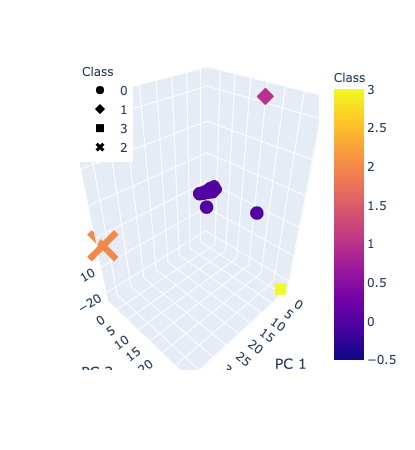

In [144]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    color="Class",
    symbol="Class",
    hover_name="CoinName",
    hover_data= ["Algorithm"],
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

#### Table of Tradable Cryptocurrencies

In [147]:
# Table with tradable cryptos
columns= ["CoinName", "Algorithm", "ProofType", "TotalCoinSupply", "TotalCoinsMined", "Class"]
clustered_df.hvplot.table(columns)

:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,Class]

In [166]:
# Print the total number of tradable cryptocurrencies
count_trading = coin_name.count()
print(f"Total number of tradable cryptocurrencies: {count_trading}")

Total number of tradable cryptocurrencies: 533


#### Scatter Plot with Tradable Cryptocurrencies

In [168]:
# Scale data to create the scatter plot
clustered_df["TotalCoinsMined"]= clustered_df["TotalCoinsMined"].astype(float)/100000000
clustered_df["TotalCoinSupply"]= clustered_df["TotalCoinSupply"].astype(float)/100000000

In [171]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
clustered_df.hvplot.scatter(x="TotalCoinsMined", y="TotalCoinSupply", color="Class", hover_cols=["CoinName"])

:Scatter   [TotalCoinsMined]   (TotalCoinSupply,Class,CoinName)